In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import multiprocessing as mp # multi radnja
from tqdm.notebook import tqdm as tqdm # progress bar
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [3]:
def read_csv(path, nrows=None):
    """Reads dataset from CSV file, with optional number of rows"""
    
    df = pd.read_csv(path, nrows=nrows)
    df['click_time'] = pd.to_datetime(df['click_time'])
    df.set_index('click_time', inplace=True)
    df.sort_index(inplace=True)
    
    return df



In [4]:
#Training data set
dataset_train = read_csv("data/train_sample.csv")

# Benchmark test
dataset_test = read_csv("data/train.csv", nrows = 10000)

#Larger test,

dataset_test_all = read_csv("data/test.csv")


Data Exploration

In [5]:
dataset_train.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [6]:
df = dataset_train.nunique()
pd.DataFrame({"atribute": df.index,"unique_values": df.values})


,atribute,unique_values
0,ip,34857
1,app,161
2,device,100
3,os,130
4,channel,161
5,attributed_time,227
6,is_attributed,2


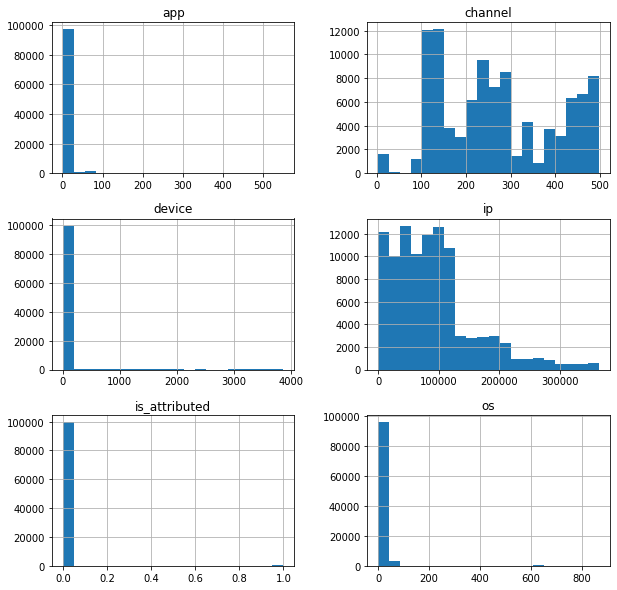

In [7]:
dataset_train.hist(bins=20, figsize=(10,10));

In [8]:
corr = dataset_train.corr()
corr.style.background_gradient()


,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


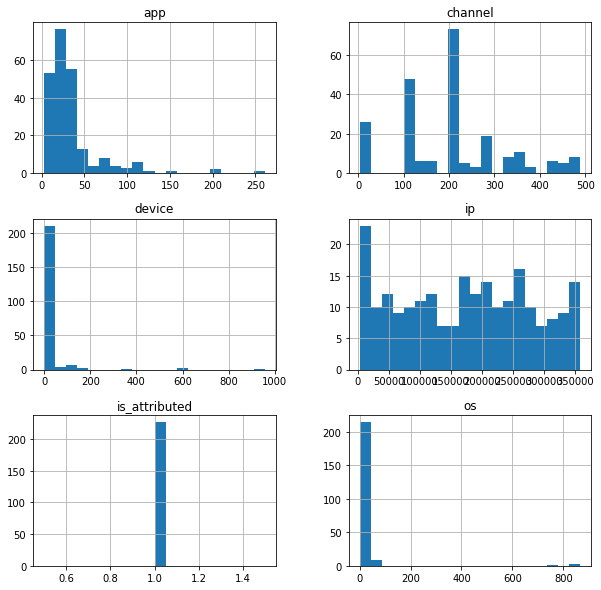

In [9]:
dataset_train[(dataset_train["is_attributed"]==1)].hist(bins = 20,figsize =(10,10));

In [10]:
top_apps = dataset_train.groupby(["app"])["is_attributed"].agg(is_attributed="sum")
top_apps.sort_values("is_attributed",ascending= False).head(10)

,is_attributed
app,
19,70
35,27
29,22
10,18
5,14
45,11
9,8
72,6
18,5


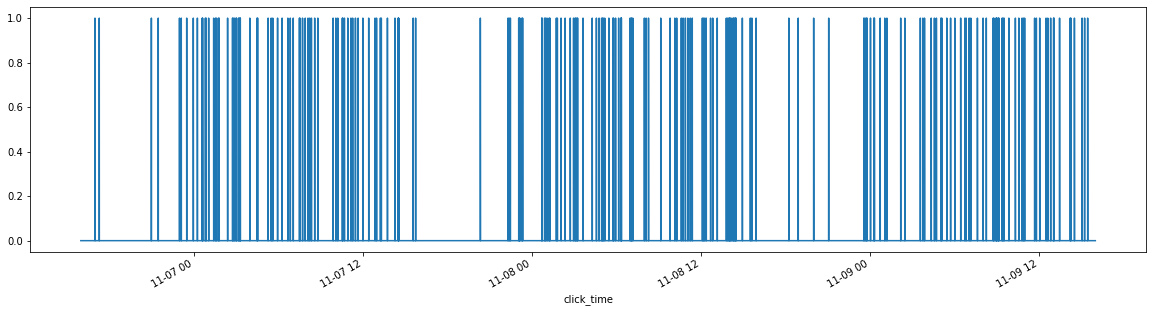

In [11]:
dataset_train.apply(lambda x: 1 if x["is_attributed"] == 1 else 0,axis=1).plot(figsize=(20,5));

Benchmark Models

In [12]:
benchmark_const = dataset_test_all[["click_id"]].copy()
benchmark_const["is_attributed"] = 0
benchmark_const.set_index("click_id",inplace=True)

In [13]:
benchmark_const

,is_attributed
click_id,
0,0
1,0
2,0
3,0
4,0
...,...
18790464,0
18790465,0
18790467,0


In [14]:
benchmark_const.to_csv("data/benchmark_const.csv")

# Preprocessing
* Extract hour of the day
 * Valid clicks are coming during the day
* For each attribute extract duration since last click with that attribute
 * Fraud might reuse same IP,app or device
* Remove attributes: attributed_time, click_time, is_attributed
 * Not need for the model


In [65]:
def prepare_column(job):
    """Generate new features from target column"""
    df = job["df"]
    col = job["feat"]
    
    print("Preparing columns",col)
    new_col = "last_" + col
    #attr map brojac iz reda
    def calculate_last(row,attr,attr_map):
        attr_val = row[attr]
        if attr_val in attr_map:
            start_time =attr_map.get(attr_val)
            end_time = row["click_time"]
            val = min((end_time- start_time).total_seconds(),86400)
            
        else:
            val = 86400
        attr_map[attr_val] = row["click_time"]
        return val
    
    df[new_col] = df.apply(calculate_last, axis=1,attr = col,attr_map ={})
    
    min_max_scaler = StandardScaler()
    x = df[[new_col]].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    df[new_col] = x_scaled
    
    return df[new_col]

def prepare_dataset(df):
    df["hour"] = df.index.hour
    df["click_time"] = df.index
    
    pool = mp.Pool(maxtasksperchild = 1000)
    jobs =[{"df":df, "feat":feat} for feat in ["ip","app","os","channel","device"]]
    
    with tqdm(total = len(jobs)) as pbar:
        for new_col in pool.imap(prepare_column,jobs):
            df = pd.concat([df, new_col],axis=1)
            pbar.update()
        
    pool.close()
    pool.join()
    return df.drop(labels =["attributed_time","click_time","is_attributed"],axis=1,errors="ignore")

In [66]:
print("Preparing train dataset")
train_X = prepare_dataset(dataset_train)
%time train_y  = dataset_train["is_attributed"]

print("Preparing test dataset")
%time test_X = prepare_dataset(dataset_test)
test_y  = dataset_test["is_attributed"]

Preparing train dataset


Preparing columns ip
Preparing columns app
Preparing columns os
Preparing columns channel
Preparing columns device

CPU times: user 145 µs, sys: 33 µs, total: 178 µs
Wall time: 181 µs
Preparing test dataset


Preparing columns app
Preparing columns ip
Preparing columns os
Preparing columns channel
Preparing columns device

CPU times: user 77.3 ms, sys: 48.6 ms, total: 126 ms
Wall time: 3.25 s


In [67]:
train_X

,ip,app,device,os,channel,hour,last_ip,last_app,last_os,last_channel,last_device
click_time,,,,,,,,,,,
2017-11-06 16:00:00,48646,12,1,19,178,16,1.047311,20.171806,23.744127,20.778738,28.898258
2017-11-06 16:00:09,93836,12,1,30,328,16,1.047311,-0.077618,23.744127,20.778738,-0.037278
2017-11-06 16:00:09,5314,8,1,13,145,16,1.047311,20.171806,23.744127,20.778738,-0.040293
2017-11-06 16:00:11,73954,23,1,19,153,16,1.047311,20.171806,-0.086441,20.778738,-0.039623
2017-11-06 16:00:11,91574,3,1,17,135,16,1.047311,20.171806,23.744127,20.778738,-0.040293
...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09 15:59:42,85592,12,1,13,145,15,-1.006492,-0.075275,-0.088648,-0.113277,-0.039958
2017-11-09 15:59:43,91779,18,1,41,379,15,1.047311,-0.077618,-0.055546,-0.102396,-0.039958
2017-11-09 15:59:44,81374,14,1,25,118,15,1.047311,-0.064258,-0.074855,0.047529,-0.039958


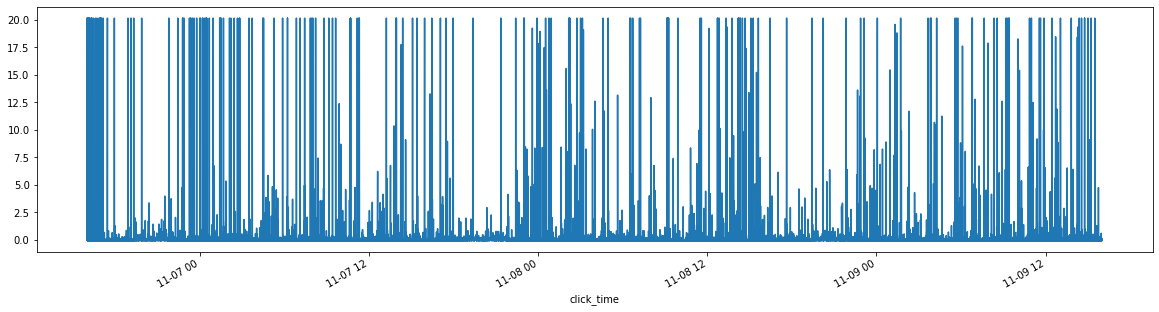

In [68]:
train_X["last_app"].plot(figsize=(20,5))

In [23]:
train_X.head()

,ip,app,device,os,channel,hour
click_time,,,,,,
2017-11-06 16:00:00,48646,12,1,19,178,16
2017-11-06 16:00:09,93836,12,1,30,328,16
2017-11-06 16:00:09,5314,8,1,13,145,16
2017-11-06 16:00:11,73954,23,1,19,153,16
2017-11-06 16:00:11,91574,3,1,17,135,16


# Model training